In [36]:
import pandas as pd
import numpy as np
import sys
import os 
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

In [3]:
sys.path.append(os.path.abspath('../../util/model'))
from training import get_percent

In [4]:
info_data_path = "../../data/raw_data/data.info"
with open(info_data_path, 'r') as f:
    info = f.read().splitlines()
data_df1 = pd.read_parquet("../../data/merged_data/merged_data_v2_1.parquet")
data_df2 = pd.read_parquet("../../data/merged_data/merged_data_v2_2.parquet")
data_df3 = pd.read_parquet("../../data/merged_data/merged_data_v2_3.parquet")

In [5]:
print(data_df1.shape)
print(data_df2.shape)
print(data_df3.shape)


(5000000, 15)
(5000000, 15)
(1027106, 15)


In [6]:
raw_df =  pd.concat([data_df1, data_df2, data_df3])

In [7]:
def model_features_and_clean(df):
    '''Function to select features for modelling and clean the initial raw data. 
        Removes rows which contain NAN values in key_columns, and converts all NAN values to 0 for non_nan_cols

    :Parameters:
    ------------
        self.df: DataFrame
            DataFrame containing raw data

    :Returns:
    ---------
        self.df: DataFrame
            DataFrame containing features required for modelling
    '''

    model_features_list = ['transcript', 'position', 'nucleotides', 'reads_count', 'gene_id',
                            'dwellingtime_-1', 'std_-1', 'mean_-1',
                            'dwellingtime_0', 'std_0', 'mean_0',
                            'dwellingtime_+1', 'std_+1', 'mean_+1','label']
    non_nan_cols = []
    key_columns = ['label'] 

    df = df[model_features_list]
    df[non_nan_cols] = df[non_nan_cols].fillna(0)
    df = df.dropna(subset=key_columns)
    return df

In [8]:
cleaned_df = model_features_and_clean(raw_df)

In [9]:
# function to clean ==> added in np.min and np.max for all 
def feature_eng(df):
    temp = pd.DataFrame(df.groupby(['gene_id', 'transcript', 'position', 'nucleotides', 'reads_count', 'label'], as_index=False)
                           .agg({'dwellingtime_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'std_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'mean_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'dwellingtime_0': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'std_0': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'mean_0': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'dwellingtime_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'std_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max],
                                'mean_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean, np.min, np.max]}))
    temp.columns = ['gene_id', 'transcript', 'position', 'nucleotides', 'reads_count', 'label',
                        'dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean','dwelling_time_-1_min', 'dwelling_time_-1_max',
                        'std_-1_25', 'std_-1_50', 'std_-1_75', 'std_-1_mean','std_-1_min', 'std_-1_max',
                        'mean_-1_25', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean','mean_-1_min', 'mean_-1_max',
                        'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean','dwelling_time_0_min','dwelling_time_0_max',
                        'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean','std_0_min', 'std_0_max',
                        'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean','mean_0_min', 'mean_0_max',
                        'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean','dwelling_time_+1_min','dwelling_time_+1_max',
                        'std_+1_25', 'std_+1_50', 'std_+1_75', 'std_+1_mean','std_+1_min', 'std_+1_max',
                        'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean','mean_+1_min', 'mean_+1_max']
    return temp

In [10]:
percentiles_df = feature_eng(cleaned_df)

In [11]:
percentiles_df['position'] = percentiles_df['position'].astype(int)
# find the relative position of each read in each transcript
percentiles_df['relative_position'] = percentiles_df.groupby(['transcript','gene_id'])['position'].transform(lambda x: (x - x.min())/(x.max()-x.min()))
# note: have NAs because there's transcripts with only one position
# fill the NAs with 0
percentiles_df['relative_position'] = percentiles_df['relative_position'].fillna(0)

In [12]:
percentiles_df.shape

(121838, 61)

In [13]:
# split the nucleotides into seven columns
## this is just to show why after encoding some positions are missing
order_df = pd.DataFrame(percentiles_df['nucleotides'].str.split('').to_list())[[x for x in range(1, 8)]].rename(
    columns = {1: 'order_0', 2:'order_1', 
               3: 'order_2', 4:'order_3', 
               5: 'order_4', 6:'order_5',
               7: 'order_6'})

order_df.head()

,order_0,order_1,order_2,order_3,order_4,order_5,order_6
0,T,A,G,A,C,C,T
1,A,A,A,A,C,T,A
2,G,A,A,A,C,A,C
3,A,T,A,A,C,T,C
4,T,A,A,A,C,A,A


In [14]:
order_df.shape

(121838, 7)

In [27]:
x = ["Position 1", "Position 2", "Position 3", "Position 4", "Position 5", "Position 6", "Position 7"]
nucleotide_counts = {"A": [], "C": [], "T": [], "G": []}

for col in list(order_df.columns):
    for nucleotide in ["A", "C", "T", "G"]:
        try:
            count = order_df[col].value_counts()[nucleotide]
            nucleotide_counts[nucleotide].append(count)
        except:
            nucleotide_counts[nucleotide].append(0)

nucleotide_counts

{'A': [38866, 45867, 57985, 121838, 0, 45622, 31695],
 'C': [22544, 0, 0, 0, 121838, 36629, 25749],
 'T': [28828, 33905, 0, 0, 0, 39587, 34922],
 'G': [31600, 42066, 63853, 0, 0, 0, 29472]}

In [35]:
nucleotide_df = pd.DataFrame(nucleotide_counts["A"], columns = ["A"], index = x)
nucleotide_df["C"] = nucleotide_counts["C"]
nucleotide_df["T"] = nucleotide_counts["T"]
nucleotide_df["G"] = nucleotide_counts["G"]
nucleotide_df.head()

,A,C,T,G
Position 1,38866,22544,28828,31600
Position 2,45867,0,33905,42066
Position 3,57985,0,0,63853
Position 4,121838,0,0,0
Position 5,0,121838,0,0


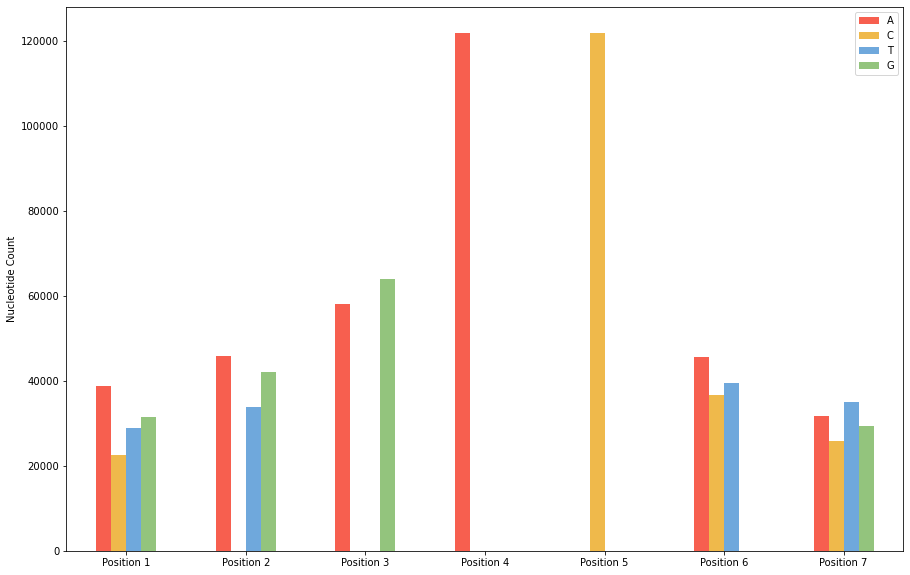

In [47]:
from turtle import width

colour_scheme = {"A": "#f75f4f", "C": "#efb94b", "T": "#6fa8dc", "G": "#93c47d"}
nucleotide_df.plot(kind = "bar", figsize = (15, 10), color = colour_scheme)

plt.ylabel("Nucleotide Count")
plt.gca().xaxis.set_tick_params(rotation = 0)

In [ ]:
indiv_df = pd.concat([percentiles_df, order_df], axis = 1)
indiv_df.head()

In [34]:
columns = ['order_0', 'order_1', 'order_2', 'order_3', 'order_4', 'order_5', 'order_6']
for col in columns:
    print(f'{col}: {indiv_df[col].unique()}')

order_0: ['T' 'A' 'G' 'C']
order_1: ['A' 'T' 'G']
order_2: ['G' 'A']
order_3: ['A']
order_4: ['C']
order_5: ['C' 'T' 'A']
order_6: ['T' 'A' 'C' 'G']


In [17]:
X_raw = percentiles_df.drop(columns = ['label'], axis = 1)
y_raw = pd.DataFrame(percentiles_df['label'].astype(int))

In [28]:
def encoding_full_data(X_raw, y_raw):
    # new numeric cols
    numeric_cols =  ['reads_count','dwelling_time_-1_25',
                    'dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'dwelling_time_-1_min', 'dwelling_time_-1_max',
                    'std_-1_25', 'std_-1_50', 'std_-1_75', 'std_-1_mean', 'std_-1_min', 'std_-1_max', 'mean_-1_25',
                    'mean_-1_50', 'mean_-1_75', 'mean_-1_mean', 'mean_-1_min', 'mean_-1_max', 'dwelling_time_0_25',
                    'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean',  'dwelling_time_0_min', 'dwelling_time_0_max',
                    'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean',  'std_0_min', 'std_0_max', 'mean_0_25',
                    'mean_0_50', 'mean_0_75', 'mean_0_mean','mean_0_min', 'mean_0_max', 'dwelling_time_+1_25',
                    'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'dwelling_time_+1_min', 'dwelling_time_+1_max',
                    'std_+1_25', 'std_+1_50', 'std_+1_75', 'std_+1_mean','std_+1_min', 'std_+1_max', 'mean_+1_25',
                    'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min','mean_+1_max', 'relative_position']
    one_hot_col = ['position_0', 'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'position_6']

    # piping the encoding
    numeric_encoder = Pipeline([('scale', StandardScaler())])
    one_hot_encoder = Pipeline([('one_hot_enocde', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("num", numeric_encoder, numeric_cols), 
                                                    ("one_hot_encode", one_hot_encoder, one_hot_col)], remainder='passthrough')

    # getting list of column names to map
    for i in range(7):
        X_raw['position_' + str(i)] = X_raw['nucleotides'].apply(lambda x: x[i])
    ref_df = X_raw # df used as reference for encoding
    columns_to_map = numeric_cols
    one_hot = OneHotEncoder(handle_unknown='ignore',use_cat_names=True)
    x_df_ohe = pd.DataFrame(one_hot.fit_transform(ref_df[one_hot_col]))
    x_df_ohe.columns = one_hot.get_feature_names()
    columns_to_map = numeric_cols + list(x_df_ohe.columns)

    print('columns after preprocessing :', columns_to_map,  '\n')

    # applying encoding on columns in df and creating pipeline
    X_raw_enc = pd.DataFrame({col: vals for vals, col in zip(preprocessor.fit_transform(ref_df, y_raw).T, columns_to_map)})
    pipe = Pipeline(steps=[("preprocessor", preprocessor)])
    pipe = pipe.fit(ref_df, y_raw)

    return X_raw_enc, pipe, columns_to_map

In [29]:
X_raw_enc, pipe, columns_to_map = encoding_full_data(X_raw, y_raw)

columns after preprocessing : ['reads_count', 'dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'dwelling_time_-1_min', 'dwelling_time_-1_max', 'std_-1_25', 'std_-1_50', 'std_-1_75', 'std_-1_mean', 'std_-1_min', 'std_-1_max', 'mean_-1_25', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean', 'mean_-1_min', 'mean_-1_max', 'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'dwelling_time_0_min', 'dwelling_time_0_max', 'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean', 'std_0_min', 'std_0_max', 'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean', 'mean_0_min', 'mean_0_max', 'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'dwelling_time_+1_min', 'dwelling_time_+1_max', 'std_+1_25', 'std_+1_50', 'std_+1_75', 'std_+1_mean', 'std_+1_min', 'std_+1_max', 'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean', 'mean_+1_min', 'mean_+1_max', 'relative_position', 'position_0_T',

In [30]:
X_raw_enc.head()

,reads_count,dwelling_time_-1_25,dwelling_time_-1_50,dwelling_time_-1_75,dwelling_time_-1_mean,dwelling_time_-1_min,dwelling_time_-1_max,std_-1_25,std_-1_50,std_-1_75,...,position_2_A,position_3_A,position_4_C,position_5_C,position_5_T,position_5_A,position_6_T,position_6_A,position_6_C,position_6_G
0,-0.506116,2.671903,1.730975,2.008774,1.465633,1.425162,-0.715276,-0.289779,-0.502084,-0.712691,...,0,1,1,1,0,0,1,0,0,0
1,-0.513397,2.954481,1.754884,1.23072,1.920001,0.016588,1.005682,-0.722286,-0.818518,-0.965746,...,1,1,1,0,1,0,0,1,0,0
2,-0.498834,0.220651,0.173918,-0.26577,0.437666,0.731387,2.288764,-0.711435,-0.536694,-0.313842,...,1,1,1,0,0,1,0,0,1,0
3,-0.513397,-0.56653,-0.522423,-0.70431,-0.481384,0.731387,-0.959673,-1.002874,-0.885265,-0.977201,...,1,1,1,0,1,0,0,0,1,0
4,-0.506116,0.572752,0.463812,1.685427,0.985092,0.016588,0.160478,-0.996673,-1.055843,-1.175063,...,1,1,1,0,0,1,0,1,0,0


In [35]:
X_raw_enc.shape

(121838, 74)

In [38]:
%cd ../../data/raw_data

/Users/xinrantao/Desktop/DSA4262-ACMXZ/data/raw_data


In [39]:
## raw data for eda
X_raw_enc.to_parquet("X_raw_enc.parquet") 
y_raw.to_parquet("y_raw.parquet")

In [56]:
list(raw_df["label"].value_counts())

[10527532, 499574]

In [57]:
label_count = pd.DataFrame(list(raw_df["label"].value_counts()), columns = ["Count"], index = ["0", "1"])
label_count

,Count
0,10527532
1,499574


In [ ]:
, color = ["#f75f4f", "#93c47d"]

Text(0.5, 0, 'Label')

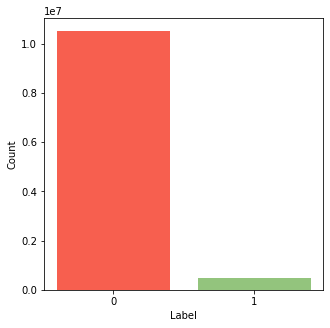

In [68]:
label_count = list(raw_df["label"].value_counts())
labels = ("0", "1")
x_pos = np.arange(2)

plt.figure(figsize = (5, 5))
plt.bar(x_pos, label_count, color = ["#f75f4f", "#93c47d"])
plt.xticks(x_pos, labels)
plt.ylabel("Count")
plt.xlabel("Label")